In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from numpy import nan as NA


# P1 Carga y Limpieza de datos

### 1. Carga

Adjuntamos df.head() al final de cada cambio importante para vizualizar como se va modificando

In [2]:
#Carga de los datos

df_all_13 = pd.read_csv("../Tarea-1-Datos/data/raw/w13/metrocuadrado_all_w13.csv", engine='python')
df_furnished_13 = pd.read_csv("../Tarea-1-Datos/data/raw/w13/metrocuadrado_all_w13.csv", engine='python')
df_all_14 = pd.read_csv("../Tarea-1-Datos/data/raw/w14/metrocuadrado_all_w14.csv", engine='python')
df_furnished_14 = pd.read_csv("../Tarea-1-Datos/data/raw/w14/metrocuadrado_furnished_w14.csv", engine='python')
df_all_15 = pd.read_csv("../Tarea-1-Datos/data/raw/w15/metrocuadrado_all_w15.csv", engine='python')
df_furnished_15 = pd.read_csv("../Tarea-1-Datos/data/raw/w15/metrocuadrado_furnished_w15.csv", engine='python')
df_all_16 = pd.read_csv("../Tarea-1-Datos/data/raw/w16/metrocuadrado_all_w16.csv", engine='python')
df_furnished_16 = pd.read_csv("../Tarea-1-Datos/data/raw/w16/metrocuadrado_furnished_w16.csv", engine='python')
df_all_17 = pd.read_csv("../Tarea-1-Datos/data/raw/w17/metrocuadrado_all_w17.csv", engine='python')
df_furnished_17 = pd.read_csv("../Tarea-1-Datos/data/raw/w17/metrocuadrado_furnished_w17.csv", engine='python')


In [3]:
#Agregamos variable categórica que diga si viene o no de un archivo "furnished"

df_all_13['furnished']=0
df_all_14['furnished']=0
df_all_15['furnished']=0
df_all_16['furnished']=0
df_all_17['furnished']=0
df_furnished_13['furnished']=1
df_furnished_14['furnished']=1
df_furnished_15['furnished']=1
df_furnished_16['furnished']=1
df_furnished_17['furnished']=1


#generamos un sólo DataFrame

frames = [df_all_13, df_furnished_13, df_all_14, df_furnished_14, df_all_15, df_furnished_15, df_all_16, df_furnished_16, df_all_17, df_furnished_17]

df = pd.concat(frames)
df1 = df

#Eliminamos filas duplicadas

df = df.drop_duplicates(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath',
       'surface', 'details', 'url', 'metrocuadrado_index'])

#Reindexamos y ordenamos para mejorar la eficiencia

df = df.reset_index(drop=True)
df.sort_index(inplace=True)

#¿cuantas filas furnished no estaban repetidas?, serán las que venían de un archivo furnished y no fueron eliminadas
#al borrar los duplicados

print("El número de filas que venían de Furnished no repetidas es",len(df[df["furnished"]>0]))

df.head()

El número de filas que venían de Furnished no repetidas es 1947


,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE BogotÃ¡ D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,"Casa en Arriendo, PARIS GAITAN BogotÃ¡ D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,"Casa en Arriendo, BALCONES DE ORIENTE BogotÃ¡ ...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0


### 2. Limpieza

In [4]:
### a.

#pasamos el precio de str a float

df["price"] = df["price"].replace('[\$,]', '', regex=True)
df["price"] = df["price"].replace('[\.,]', '', regex=True).astype(float)


#mismo ejercicio con la superficie y resto de columnas
df["surface"] = df["surface"].replace('[\ m2,]', '', regex=True).astype(float)


#si tiene más de 5 piezas o baños los agruparemos como que tienen 6
df["n_rooms"] = df["n_rooms"].replace('[\5+,]', '6', regex=True).astype(float)
df["n_bath"] = df["n_bath"].replace('[\5+,]', '6', regex=True).astype(float)

df.head()

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE BogotÃ¡ D.C..",1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,"Casa en Arriendo, PARIS GAITAN BogotÃ¡ D.C..",3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,"Casa en Arriendo, BALCONES DE ORIENTE BogotÃ¡ ...",1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0


In [5]:
### b.

#Separamos la columna original en tres y luego la eliminamos

df["property_type"] = df['property_type|rent_type|location'].str.split(expand=True)[0]
df["property_type"] = df["property_type"].replace('[\,,]', '', regex=True)

#hay que notar que no hay casas al venta solamente, son un subconjunto de las en renta
df["rent_type"] = df['property_type|rent_type|location'].str.split(expand=True)[2]
df["rent_type"] = df["rent_type"].replace('[\,,]', '', regex=True)

#nos quedamos con el nombre de la localidad
def location(row):
    p = re.compile(", (.*) Bogot")
    result = p.search(row["property_type|rent_type|location"])
    if type(result)==type(None):
        return NA
    else:
        return result.group(1)
    
df['location'] = df.apply (lambda row: location(row), axis=1)
print("Número de filas con valor NaN en locación:",abs(sum(df['location'].notna())-df.shape[0]))

#al ser pocos datos los que no tienen locación los eliminamos pues generan problemas en el tratamiento de los datos más adelante
#además de que al enriquecer la información estos perderan peso 
df = df[df['location'].notna()]

#dflocation = df['property_type|rent_type|location'].str.split().str[-5:-2]
#df["location"] = dflocation=dflocation.iloc[:,].apply(lambda x: ' '.join(x))

del df['property_type|rent_type|location']

df.head()

Número de filas con valor NaN en locación: 260


,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE


### 3. Calculo nuevas columnas

In [6]:
### a.

#creamos función para calcular el precio por metro cuadrado, excepto los casos en que la superficie sea 0

def price_per_m2 (row):
    if row['surface'] == 0 :
        return NA
    else:
        return row["price"]/row["surface"]
    
#creamos la nueva variable que guarde esta info

df['price per m2'] = df.apply (lambda row: price_per_m2(row), axis=1)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000


In [7]:
### b.

#creamos una funcion que busca el número de garajes en el str del url

def n_garajes(row):
    p = re.compile("(\d)-garaje")
    result = p.search(row["url"])
    if type(result)==type(None):
        return 0
    else:
        return int(result.group(1))
    
#creamos la nueva variable que guarde esta info

df['n_garajes'] = df.apply (lambda row: n_garajes(row), axis=1)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1


###  4. Clasificación

In [8]:
#Clasificamos el inmueble según los metros cuadrados, notese que hay casas y apartamentos más grandes y más pequeños que esos 
#margenes y lo apilamos en sus propias clases


df1=df.query('property_type=="Casa" and 80<=surface<120')
df2=df.query('property_type=="Casa" and 120<=surface<180')
df3=df.query('property_type=="Casa" and 180<=surface<240')
df4=df.query('property_type=="Casa" and 240<=surface<360')
df5=df.query('property_type=="Casa" and 360<=surface<=460')
df6=df.query('property_type=="Apartamento" and 40<=surface<60')
df7=df.query('property_type=="Apartamento" and 60<=surface<80')
df8=df.query('property_type=="Apartamento" and 80<=surface<=120')

#clases extras definidas por nosotros

df9=df.query('property_type=="Casa" and surface<80')
df10=df.query('property_type=="Casa" and 460<surface')
df11=df.query('property_type=="Apartamento" and surface<40')
df12=df.query('property_type=="Apartamento" and 120<surface')

#inicializamos la nueva columna

df["product_type"]=0

#Agregamos la clasificación de cada uno según los indices

for i in range(12):
    a=globals()["df" + str(i+1)]
    for j in a.index:
        df.loc[j, 'product_type'] = i+1
        
        
df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes,product_type
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1,9
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0,9
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1,1


### 5. Obtención UPZ

In [9]:
#importamos la info

dfupz = pd.read_csv("../Tarea-1-Datos/data/asignacion_upz/barrio-upz.csv", engine='python')

In [10]:
#Nos deshacemos de los valores NaN para poder trabajar la info

def pro_location(loc):
    if type(loc) == str:
        size = loc.strip()
        if len(size) != 0:
            return loc
    else:
        return 'NaN'

dfupz['pro_location'] = dfupz['pro_location'].apply(pro_location)

#mismo formato

dfupz['pro_location'] = dfupz['pro_location'].apply(str.upper)

In [11]:
# Inicializamos la columna, sin usar valores NaN
df['upz'] = -1
df['uplArea'] = -1

#hacemos el match según la locación

def fusion_upz(df):
    
    locations = list(dfupz['pro_location'])
    upz_codes = list(dfupz['UPlCodigo'])
    uplAreas = list(dfupz['UPlArea'])
    
    for uplArea, upz_code, location in zip(uplAreas, upz_codes, locations):
        ind = df[df['location'].str.contains(location)].index
        
        for i in ind:
            df.loc[i,'upz'] = upz_code
            df.loc[i,'uplArea'] = uplArea
    
    return df

#actualizamos

df = fusion_upz(df)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes,product_type,upz,uplArea
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1,9,UPZ101,2.357008e+06
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1,1,-1,-1.000000e+00
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0,1,UPZ75,4.964574e+06
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0,9,UPZ29,3.732645e+06
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1,1,UPZ12,2.906631e+06


In [12]:
#Vemos cual es el porcentaje de valores que tiene código UPZ, notamos que es cercano a lo esperado e incluso mejor

print('Porcentaje con upz aprox:', int(len(df[df['upz'] != -1])/len(df)*100), "% ")

Porcentaje con upz aprox: 93 % 


### 6. Enriquecimiento

In [13]:
#Importamos la información y limpiamos un poco para manejarla mejor

df_est_pob = pd.read_csv("../Tarea-1-Datos/data/estadisticas_upz/estadisticas_poblacion.csv", engine='python')
df_est_pob.drop(["Unnamed: 0", "nomupz"], axis=1, inplace=True)

df_ind_ins = pd.read_csv("../Tarea-1-Datos/data/estadisticas_upz/indice_inseguridad.csv", engine='python')
df_ind_ins.drop(["Unnamed: 0", "UPlNombre2"], axis=1, inplace=True)
df_ind_ins = df_ind_ins.rename(columns = {'UPlCodigo' : 'upz'})

df_por_ver = pd.read_csv("../Tarea-1-Datos/data/estadisticas_upz/porcentaje_areas_verdes.csv", engine='python')
df_por_ver.drop(["Unnamed: 0"], axis=1, inplace=True)
df_por_ver = df_por_ver.rename(columns = {'upz' : 'zone'})
df_por_ver = df_por_ver.rename(columns = {'cod_upz' : 'upz'})

#Arreglamos formato
def por_ver(row):
    return str("UPZ"+str(int(row["upz"])))

df_por_ver["upz"] = df_por_ver.apply (lambda row: por_ver(row), axis=1)


In [14]:
#fucionamos información

df_info1 = df_est_pob.merge(df_por_ver, on = 'upz',how = 'left')
df_info = df_info1.merge(df_ind_ins, on = 'upz',how = 'left')
df = df.merge(df_info, on = 'upz',how = 'left')


#agregamos columna de densidad

def poulation_density(row):
    if row['uplArea'] == 0 :
        return NA
    else:
        return row["personas"]/row["uplArea"]
    
df['poulation density'] = df.apply (lambda row: poulation_density(row), axis=1)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,...,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,zone,areas_verdes_perc,indice_inseguridad,poulation density
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,...,0.6,18.4,7.2,145.7,44.896230,5.281135,Teusaquillo,6.563105,3.629032,0.008252
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,...,0.4,1.2,14.5,45.4,31.113458,14.928786,FontibÃ³n,21.756250,0.310559,0.036203
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,...,1.1,0.8,12.6,71.1,37.073314,8.406360,Minuto de Dios,37.852289,1.029160,0.041894
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicaciÃ...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,...,1.8,16.7,9.1,54.7,36.279630,5.420442,Toberin,32.395663,3.166227,0.017215


In [15]:
#Info dataframe resultante, númerp de columnas esperados y poca perdida de filas a lo largo del proceso (luego de la 
#eliminación de duplicados)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 0 to 18013
Data columns (total 27 columns):
price                                      18014 non-null float64
n_rooms                                    17980 non-null float64
n_bath                                     17782 non-null float64
surface                                    18014 non-null float64
details                                    17949 non-null object
url                                        18014 non-null object
metrocuadrado_index                        18014 non-null float64
furnished                                  18014 non-null int64
property_type                              18014 non-null object
rent_type                                  18014 non-null object
location                                   18014 non-null object
price per m2                               17737 non-null float64
n_garajes                                  18014 non-null int64
product_type                              

In [16]:
df.isnull().sum()

price                                         0
n_rooms                                      34
n_bath                                      232
surface                                       0
details                                      65
url                                           0
metrocuadrado_index                           0
furnished                                     0
property_type                                 0
rent_type                                     0
location                                      0
price per m2                                277
n_garajes                                     0
product_type                                  0
upz                                           0
uplArea                                       0
personas                                   1161
trabajoinf_ninos_5_17_anos_perc            1161
trabajoinfampliado_ninos_5_17_anos_perc    1161
jovenes_14_24_anos_nini_perc               1161
indice_envegecimiento                   

# P2 EDA

### 1. Estilo de gráficos


In [ ]:
#aplica un estilo de graficos por defecto
def estilo():
    sns.set_style("dark")
    sns.set_context('notebook')
    print(sns.plotting_context())

estilo()

### 2. Perfilamiento

In [18]:
names = ['numeric', 'categorical']

# Se crea una lista con las columnas numericas
numeric = [
    'price', 'n_rooms', 'n_bath', 'surface',
    'metrocuadrado_index', 'price per m2', 'n_garajes', 'product_type',
    'personas', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'jefe_mujer_perc',
    'adultos_mayores_pobres_perc', 'areas_verdes_perc', 'indice_inseguridad', 'uplArea', 'poulation density'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)
df.columns = pd.MultiIndex.from_tuples(mapping)

df.head()

numeric                                                           \
       price n_rooms n_bath surface metrocuadrado_index  price per m2   
0  1050000.0     3.0    2.0    63.0                25.6  16666.666667   
1  3930000.0     3.0    2.0   100.0                57.3  39300.000000   
2   750000.0     3.0    1.0    90.0                12.2   8333.333333   
3  3400000.0     5.0    4.0    71.0                56.0  47887.323944   
4  1560000.0     4.0    3.0    96.0                47.1  16250.000000   

                                                                    ...  \
  n_garajes product_type  personas trabajoinf_ninos_5_17_anos_perc  ...   
0         1            9   19451.0                             0.6  ...   
1         1            1       NaN                             NaN  ...   
2         0            1  179732.0                             0.4  ...   
3         0            9  156375.0                             1.1  ...   
4         1            1   50037.0                             1.8  ...   

                                   \
        uplArea poulation density   
0  2.357008e+06          0.008252   
1 -1.000000e+00               NaN   
2  4.964574e+06          0.036203   
3  3.732645e+06          0.041894   
4  2.906631e+06          0.017215   

                                         categorical                \
                                                 url property_type   
0  https://www.metrocuadrado.com/inmueble/arriend...          Casa   
1  https://www.metrocuadrado.com/inmueble/arriend...          Casa   
2  https://www.metrocuadrado.com/inmueble/arriend...          Casa   
3  https://www.metrocuadrado.com/inmueble/arriend...          Casa   
4  https://www.metrocuadrado.com/inmueble/arriend...          Casa   

                                                                   \
                       location            zone rent_type     upz   
0              LA SOLEDAD NORTE     Teusaquillo  Arriendo  UPZ101   
1   CIUDAD SALITRE SUR-ORIENTAL             NaN  Arriendo      -1   
2  VILLA DE LOS ALPES II SECTOR       FontibÃ³n  Arriendo   UPZ75   
3                  PARIS GAITAN  Minuto de Dios  Arriendo   UPZ29   
4           BALCONES DE ORIENTE         Toberin  Arriendo   UPZ12   

                                                                
                                             details furnished  
0  Excelente casa cerca de la calle 80 y Avenida ...         0  
1  Se arrienda casa bonita totalmente amoblada co...         0  
2  CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...         0  
3  casa ezquinera excelente ubicacion cinco alcob...         0  
4  Excelente casa de tres niveles, buena ubicaciÃ...         0  

[5 rows x 27 columns]

In [19]:
# se remmplazan nans por -1
for name in numeric:
    df[('numeric',name)].fillna(-1, inplace = True)
for name in categorical:
    df[('categorical', name)].fillna('NaN', inplace = True)


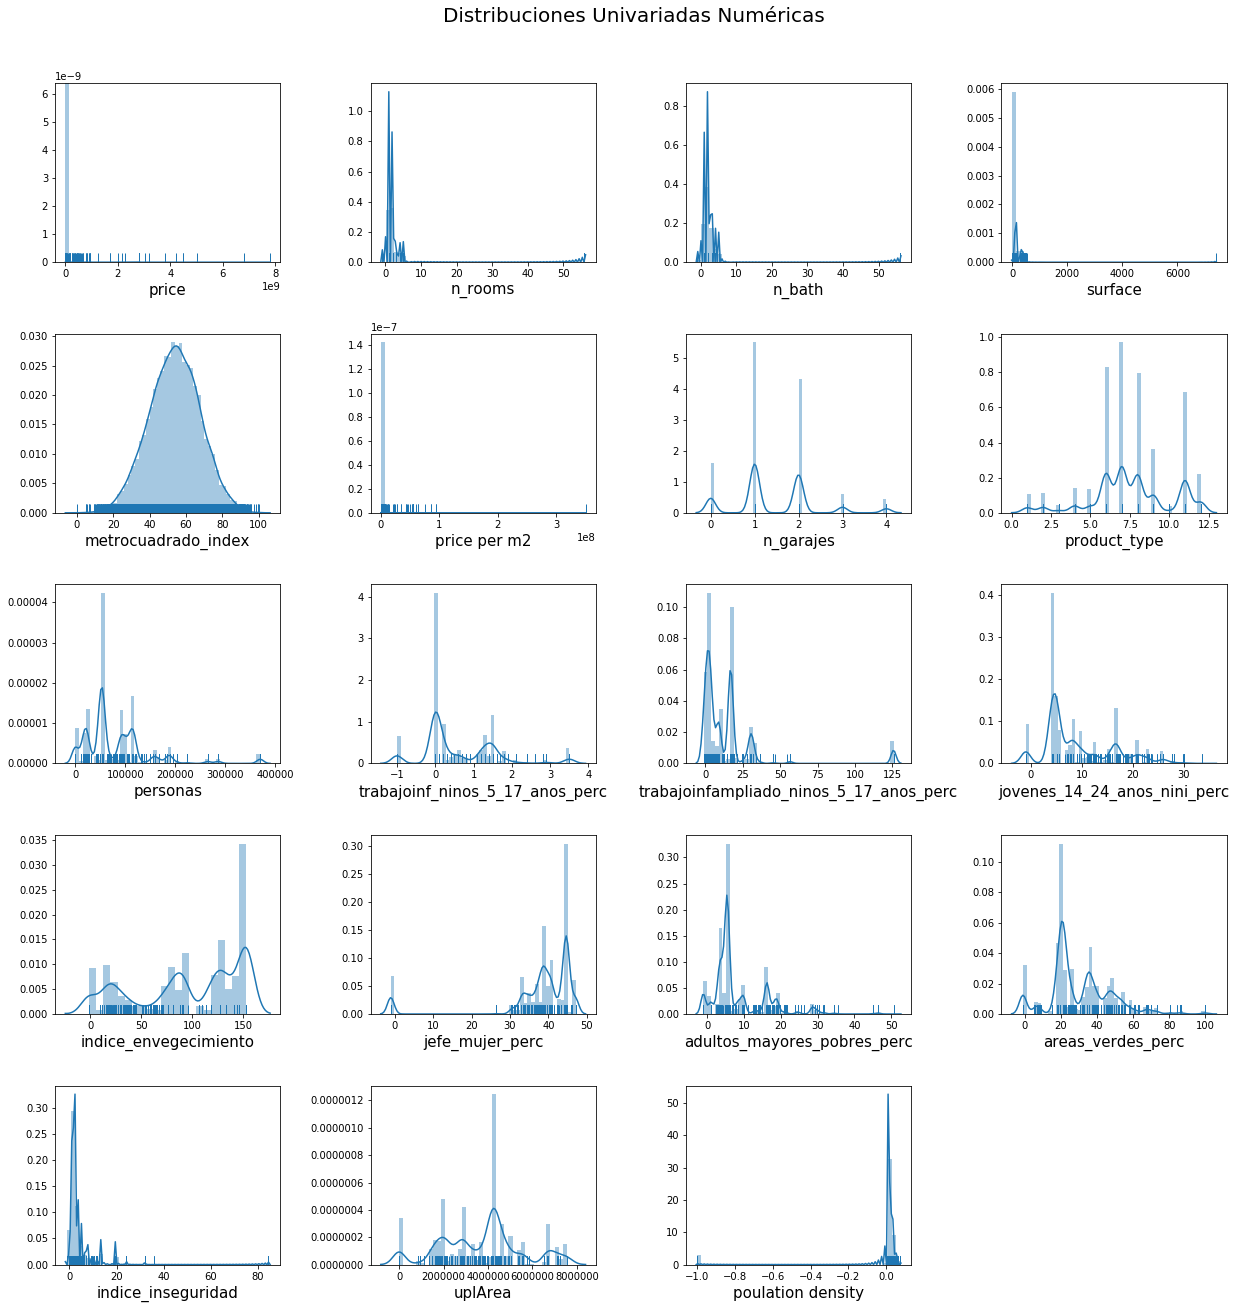

In [22]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=[17, 17])


list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [23]:
#caracter problematico
df[('categorical','zone')][2]='Fontibon'

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0           Teusaquillo
1                   NaN
2              Fontibon
3        Minuto de Dios
4               Toberin
              ...      
18009        Chico Lago
18010        Chico Lago
18011        Chico Lago
18012     Santa Barbara
18013        El Refugio
Name: (categorical, zone), Length: 18014, dtype: object

AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

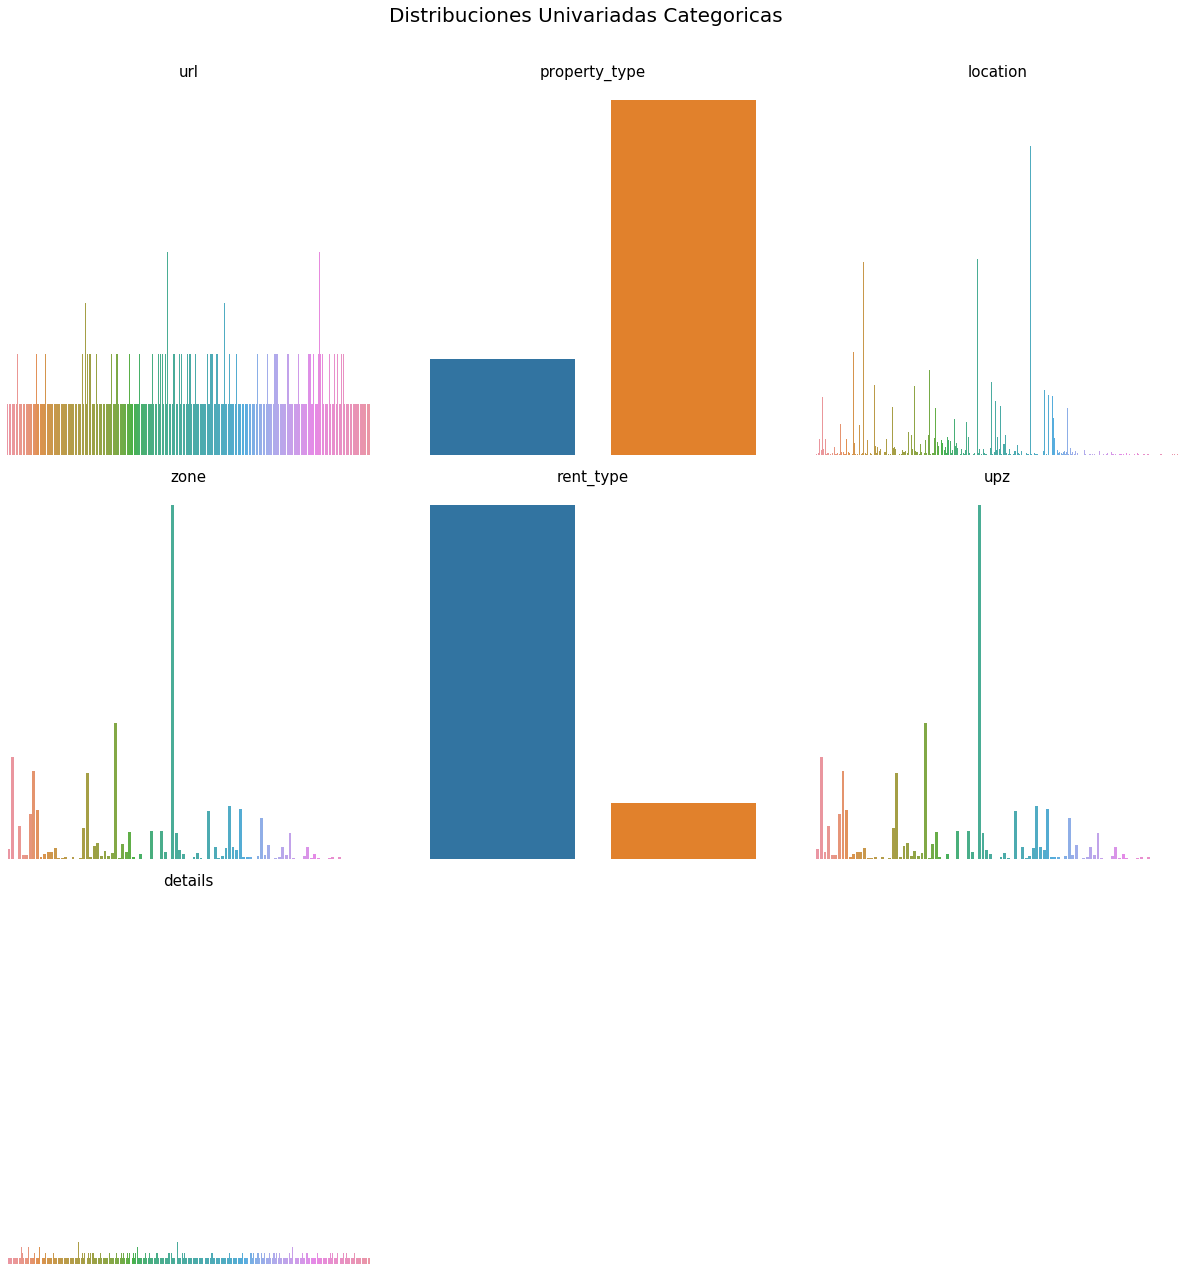

In [24]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[17, 17])


list(map(lambda a : a.remove(), ax[-1,-2:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Categoricas',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), categorical):

    # Graficos para datos tipos str
    sns.countplot(df[('categorical', col)], ax=axis)
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
  
    
# Se ajusta el espaciado interno entre subplots
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

### 3. Datos faltantes

In [25]:
#se recuperan los valores nan
df.replace(-1,NA, inplace = True) 
df.replace('NaN',NA, inplace = True) 
df.isnull().sum()

numeric      price                                         0
             n_rooms                                      34
             n_bath                                      232
             surface                                       0
             metrocuadrado_index                           0
             price per m2                                277
             n_garajes                                     0
             product_type                                  0
             personas                                   1161
             trabajoinf_ninos_5_17_anos_perc            1161
             trabajoinfampliado_ninos_5_17_anos_perc    1161
             jovenes_14_24_anos_nini_perc               1161
             indice_envegecimiento                      1161
             jefe_mujer_perc                            1161
             adultos_mayores_pobres_perc                1161
             areas_verdes_perc                          1161
             indice_inse

In [27]:
!pip install missingno

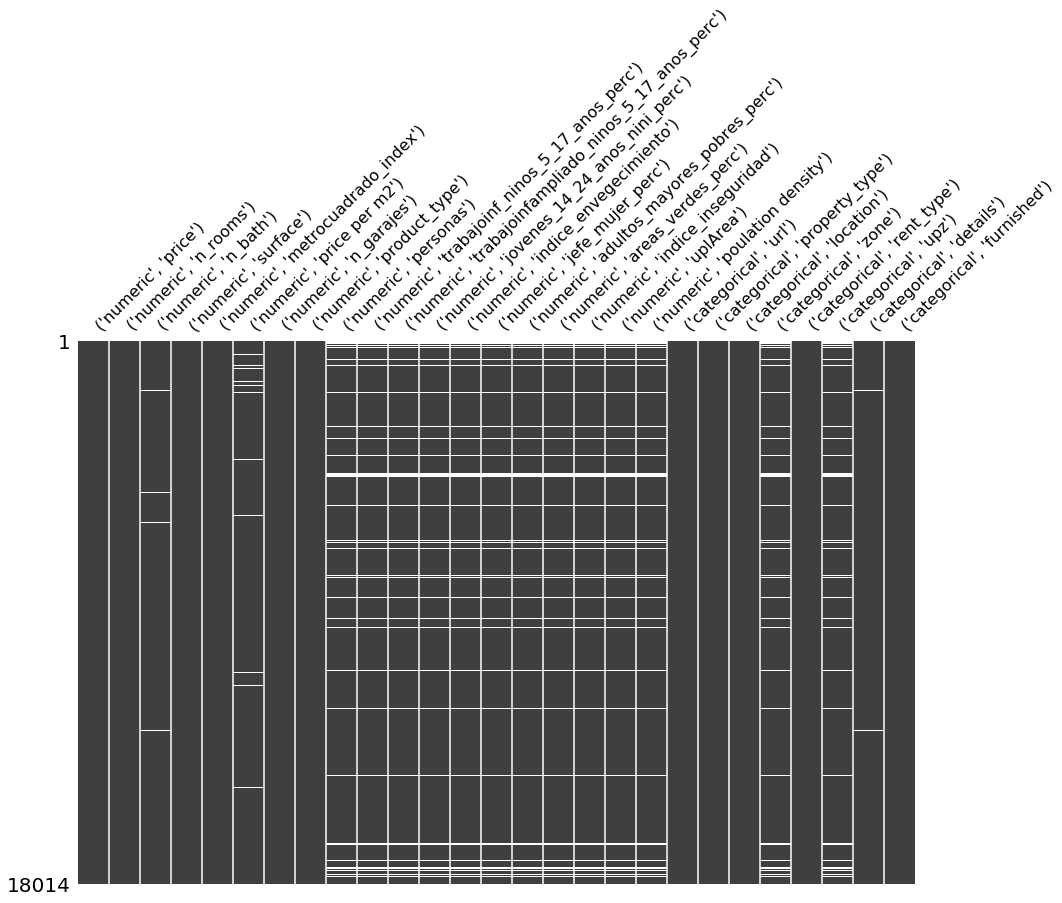

In [28]:
import missingno as msno
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=False)

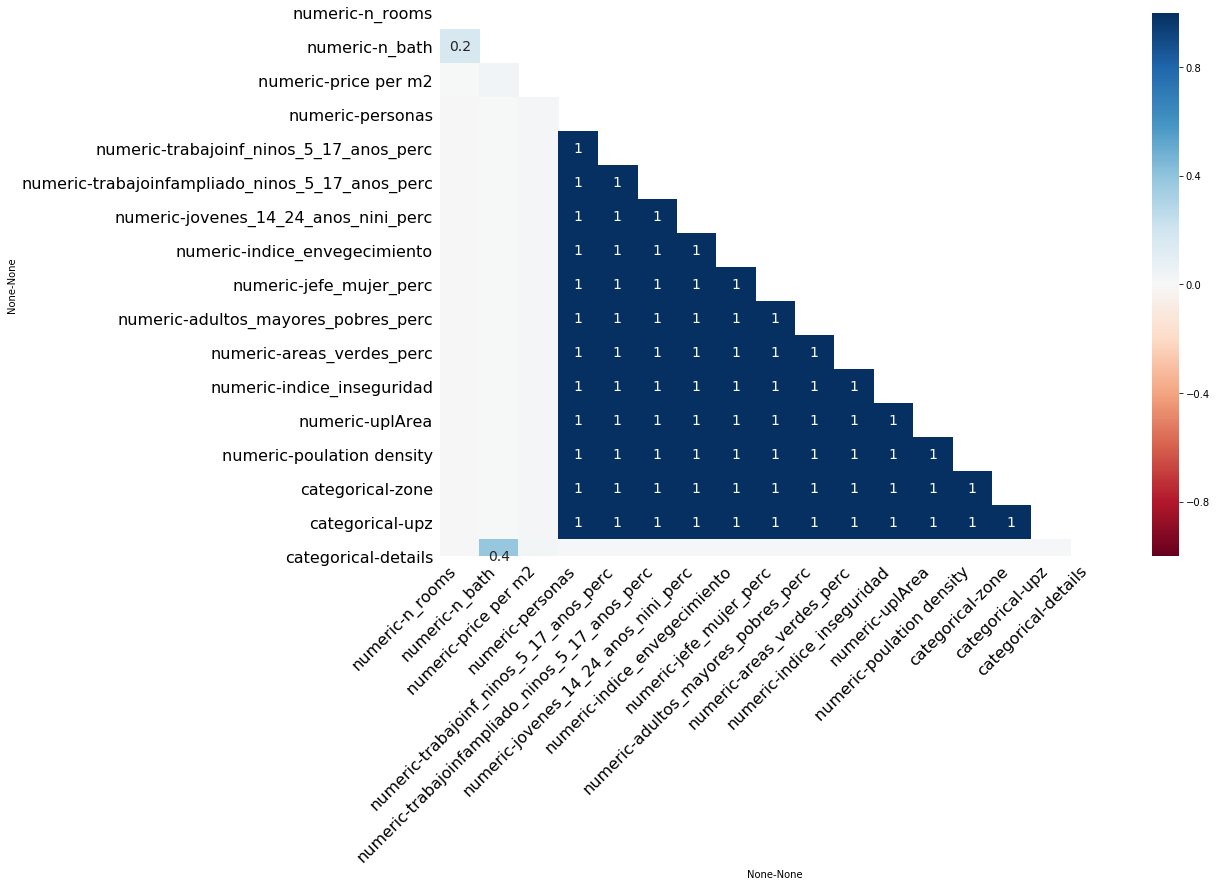

In [29]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Pipeline categorica
cat_pipe = Pipeline(
    steps=[('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')), 
           ('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))])

#Pipeline numerica
num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

In [33]:
#sin variable dependiente 'price per m2'
num = [
    'price', 'n_rooms', 'n_bath', 'surface',
    'metrocuadrado_index', 'n_garajes', 'product_type',
    'personas', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'jefe_mujer_perc',
    'adultos_mayores_pobres_perc', 'areas_verdes_perc', 'indice_inseguridad', 'uplArea', 'poulation density'
]

#sin variable url,details,location,zone
cat=[
 'furnished',
 'rent_type',
 'property_type',
 'upz',
]

In [34]:
print(len(num) + len(cat))

22


In [35]:
#Preprocesador Compuesto
prep = ColumnTransformer(
    transformers=[('num', num_pipe, num), 
                  ('cat', cat_pipe, cat)])

In [37]:
# Variables regresoras
X = df.drop(['price per m2','url','details', 'location', 'zone'], axis=1, level=1).copy()
print(X.shape)
# Variable dependiente
y = df[('numeric','price per m2')].copy()
print(y.shape)

(18014, 22)
(18014,)


In [38]:
X.columns = X.columns.droplevel(0)
X_prep = prep.fit_transform(X)

In [39]:
# Se obtienen las variables categoricas transformadas
post_cat = prep.named_transformers_['cat'][-1]
cat_cols_fit = post_cat.get_feature_names(cat)
# cantidad de columnas luego de agregar dummies
post_cols = list(num) +list(cat_cols_fit) 
len(post_cols)

125

In [40]:
df_post = pd.DataFrame(data=X_prep, columns=post_cols)
df_post.shape

(18014, 125)

In [44]:
import sys
sys.path.append('C:/Users/camil/Tarea-1-Datos')

In [45]:
from mcar import little_mcar
little_mcar(df_post)

#if p>0.05 -> MCAR else MAR/MNAR

{'chi_stat': -2.0952853610726062e+18, 'deg_f': 17889, 'p_value': 1.0}

In [46]:
#se calcula nueva columna dependiente con los datos estandarizados
df_post['price_per_m2'] = df_post['price'] / df_post['surface'] 
df_post.shape

In [48]:
#Dado que p>0.05 los datos faltantes siguen la hipotesis MCAR entonces se eliminan
df_post=df_post.dropna()
df_post.shape

(16618, 126)

In [50]:
#se eliminan columnas price y surface
df_post=df_post.drop(columns=['price', 'surface'])
df_post.head()

,n_rooms,n_bath,metrocuadrado_index,n_garajes,product_type,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,...,upz_UPZ92,upz_UPZ93,upz_UPZ94,upz_UPZ95,upz_UPZ96,upz_UPZ97,upz_UPZ98,upz_UPZ99,upz_missing,price_per_m2
0,0.644773,-0.199527,-2.015582,-0.466140,0.56778,-1.022352,-0.113018,0.110317,-0.397838,0.922808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235487
2,0.644773,-0.844028,-2.977555,-1.571598,-2.64163,1.482456,-0.340241,-0.605272,0.748597,-1.219174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.708959
3,1.913851,1.089477,0.166806,-1.571598,0.56778,1.117442,0.455039,-0.621913,0.450210,-0.670331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237445
4,1.279312,0.444975,-0.472117,-0.466140,-2.64163,-0.544366,1.250318,0.039590,-0.099451,-1.020565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.858434
5,0.644773,-0.199527,-1.527416,-1.571598,0.56778,1.158308,-0.340241,-0.580309,1.172621,-1.659102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303277


### 4. UPZ clustering

### 5. Relaciones entre variables

In [54]:
interest = [
    'metrocuadrado_index', 'product_type',
    'personas', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'jefe_mujer_perc',
    'adultos_mayores_pobres_perc', 'areas_verdes_perc', 'indice_inseguridad', 'uplArea', 'poulation density' , 'price_per_m2'      
]

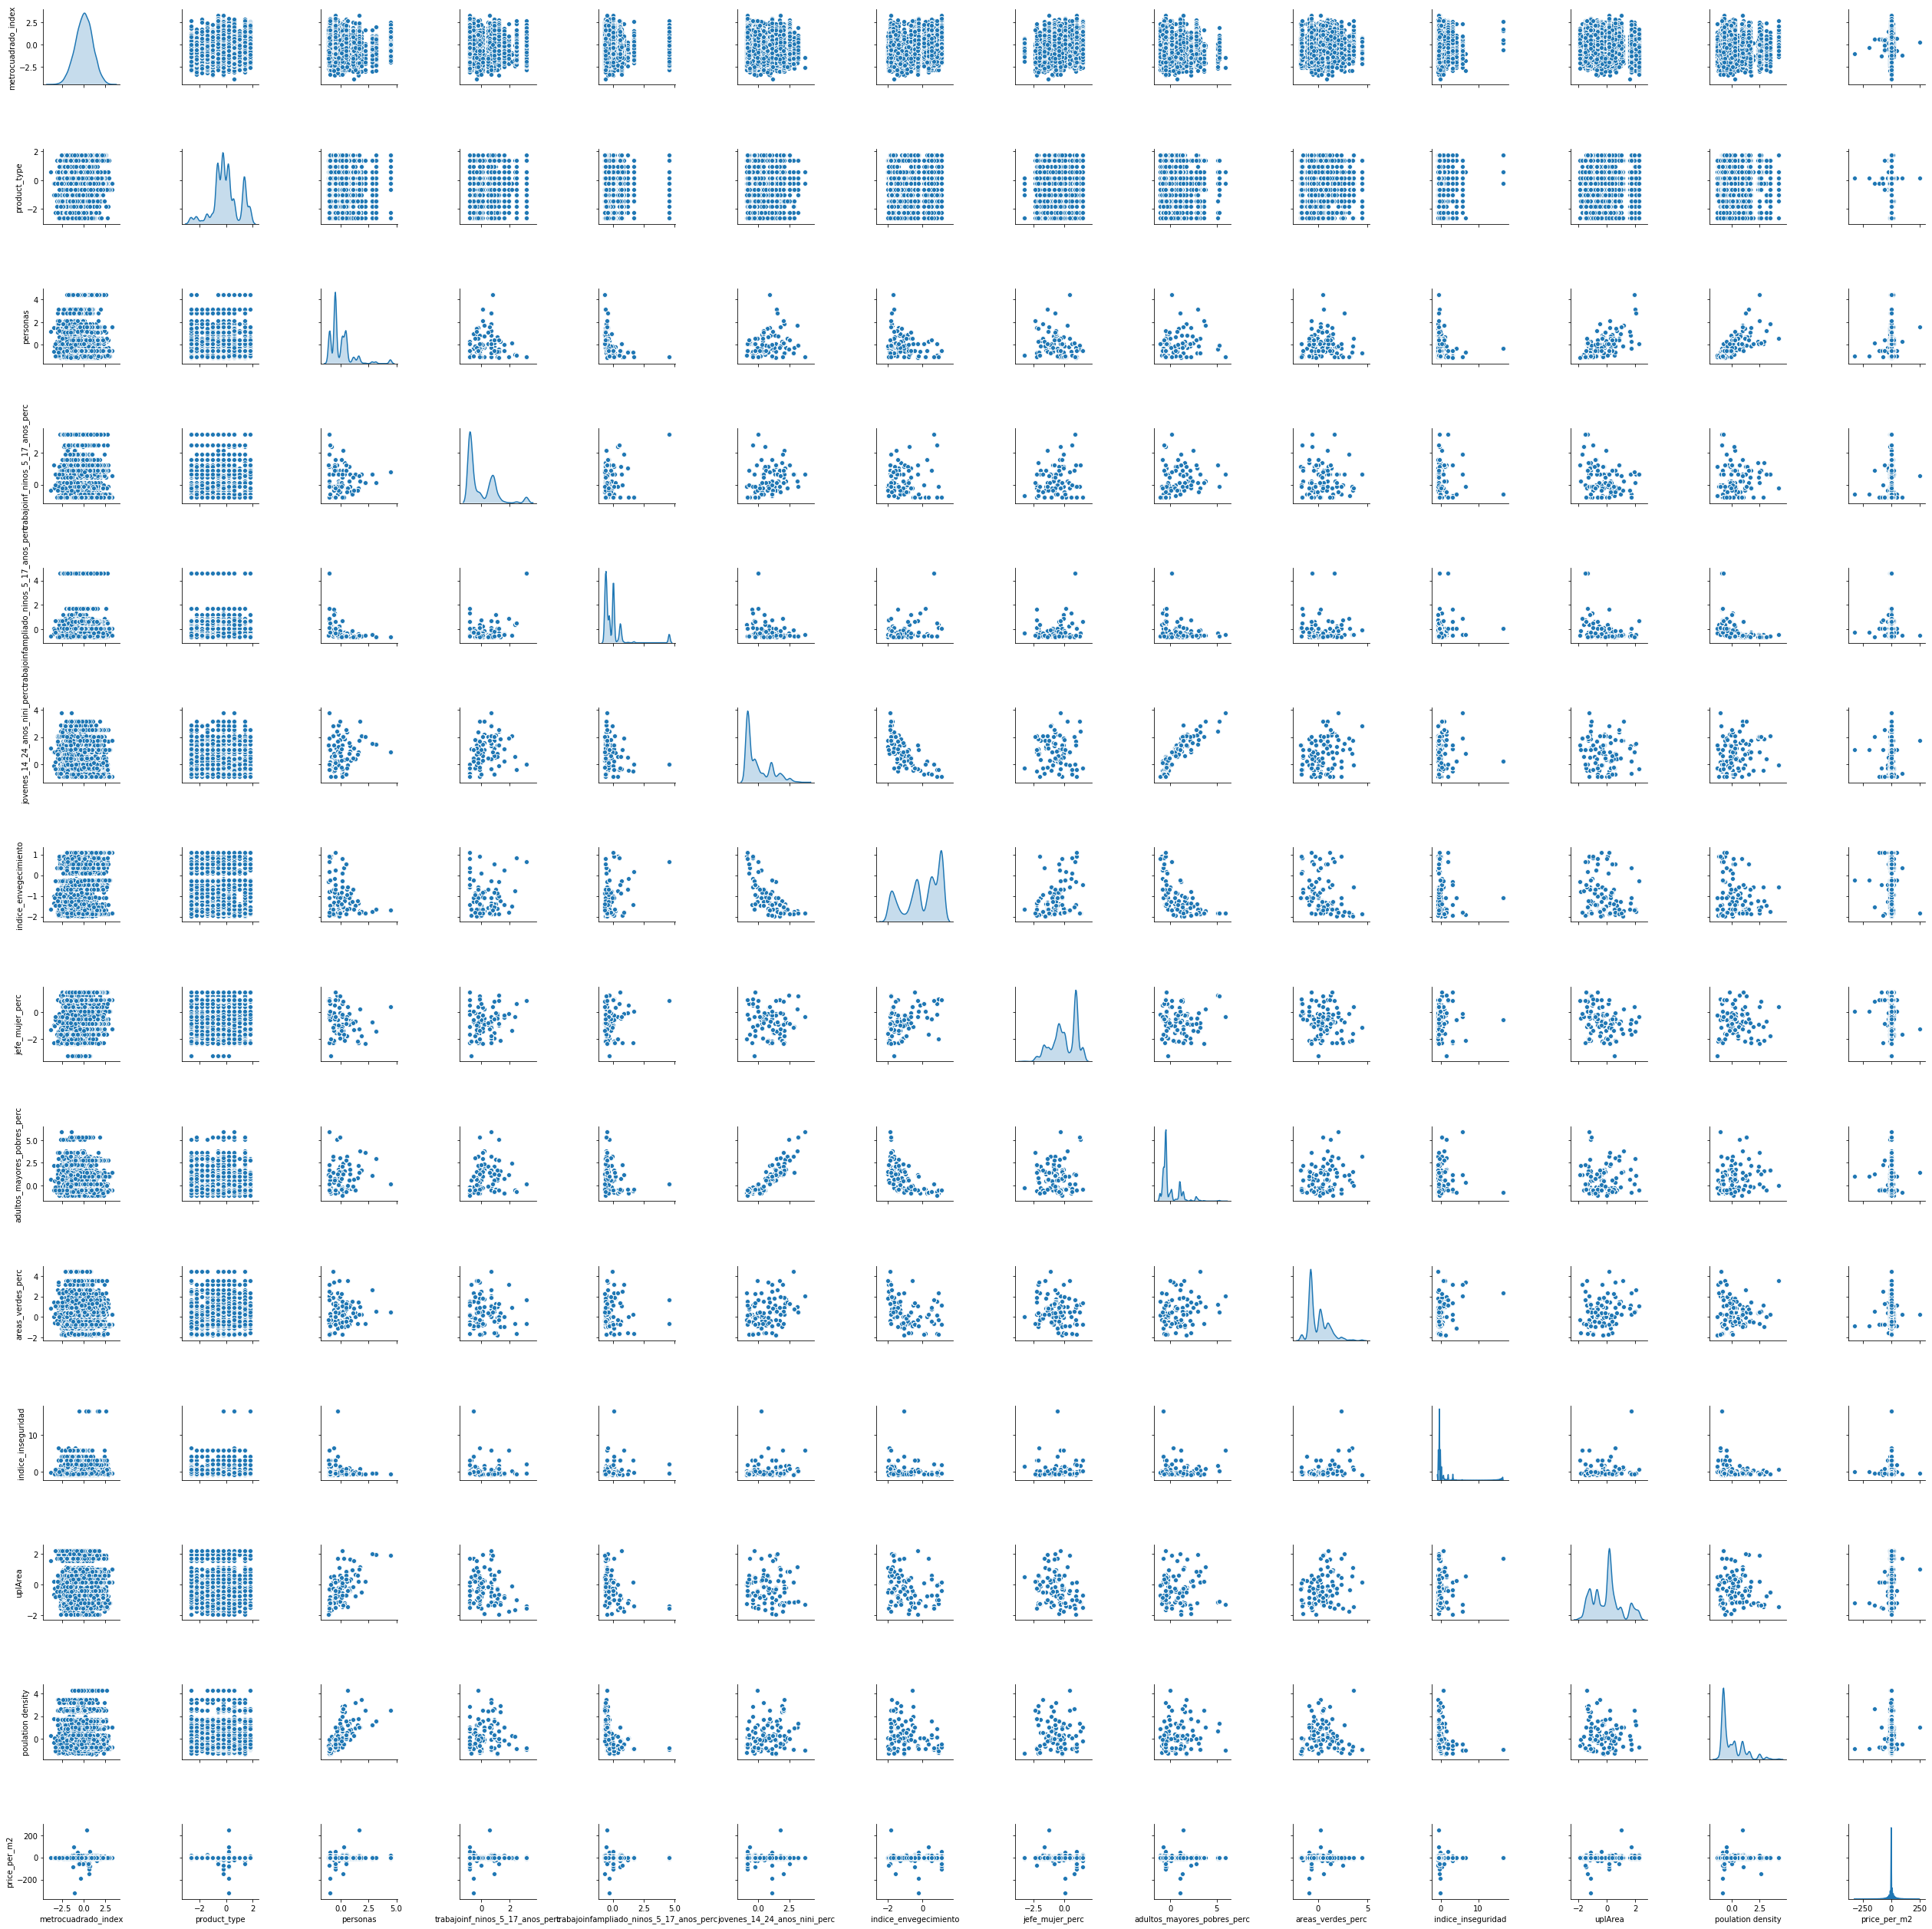

In [55]:
sns.pairplot(data = df_post[interest], diag_kind='kde')

In [ ]:
corrmat = df_post.corr()
col = indexer(['price per m2'])
corrmat[col].nlargest(3,col)

In [ ]:
corrmat[col].nsmallest(3,col)

In [ ]:
unsorted = list(corrmat.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

# P3 Regresión Lineal Bayesiana

### Desarrollo teórico:

Dado un conjunto de observaciones $D= \{(x_i,y_i)\}_{i=1}^N$ $\in \mathbb{R}^{d-1}\times \mathbb{R}$, el modelo de regresión lineal, concibe el problema de regresión mediante el esquema:

$$ y_i = w_0 + \sum_{j=1}^{d-1}w_jx_{i,j} + \varepsilon_j = \textbf{w}^T\textbf{x}_i + \varepsilon_j \tag{1}$$

con la convención $x_{i,0} = 1$ $\forall i\,\in\{1,\cdots,N\}$ y con $\varepsilon_j \sim \mathcal{N}(0,\beta^{-1})$ i.i.d. $\forall i\,\in\{1,\cdots,N\}$. Dada la suposición de normalidad del error, es decir $\varepsilon_j \sim \mathcal{N}(0,\beta^{-1})$, la verosimilitud para una observación es expresada según

$$ p(y_i|\textbf{x}_i,\textbf{w},\beta)\sim \mathcal{N}(\textbf{w}^T\textbf{x}_i,\beta^{-1}). \tag{*}$$

Para este problema, la familia de funciones aproximadoras $\mathcal{M}$, denominada como $modelo$, corresponde a las funciones lineales representadas por $\textbf{w}$. Así, si se escribe la verosimilitud anterior como $p(\mathcal{D}|\mathcal{M})$, según el Teorema de Bayes, se tiene

$$ p(\mathcal{M}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathcal{M})p(\mathcal{M})}{p(\mathcal{D})} \tag{2}$$

Es decir, la probabilidad posterior $p(\mathcal{M}|\mathcal{D})$ de elegir una función aproximadora, dado el cunjunto de datos, puede ser calculada en función de una probabilidad a priori, sobre el modelo $p(\mathcal{M})$, la verosimilitud $p(\mathcal{D}|\mathcal{M})$ y la evidencia $p(\mathcal{D})$. El enfoque bayesiano consiste en modelar una probabilidad a priori $p(\mathcal{M})$ para obtener la función que mejor modele los datos utilizando la expresión (2) para trabajar con $p(\mathcal{M}|\mathcal{D})$. Observe que en el caso del modelo lineal (1), obtener una expresión para $p(\mathcal{M})$, es equivalente a modelar una distribución sobre $\textbf{w}$.

1. Utilice una distribución gaussiana isotrópica sobre los parámetros $\textbf{w}$ con media cero:

$$p(\textbf{w}|\alpha) \sim \mathcal{N}(0,\alpha^{-1}\textbf{I})$$

considere que $p(\mathcal{D})$ es una constante. Con esto, muestre que la distribución posterior de los parámetros $\textbf{w}$ es proporcional a 

$$ p(\textbf{w}|\textbf{y},\textbf{X},\alpha,\beta) \sim \mathcal{N}(m_N,\textbf{S}_N)$$

donde

$$m_N = \beta\, \textbf{S}_N\textbf{X}^T\textbf{y}$$

$$\textbf{S}_N^{-1} = \alpha\,\textbf{I} + \beta\, \textbf{X}^T\textbf{X}$$

$\textbf{Solución 1}$: Primero notemos lo siguiente. Dada la densidad $\textit{a priori}$ de $y_i$, definamos como $\textbf{y} = (y_1,\cdots,y_N)^T$. Por lo tanto, por lo definido en $(*)$, sabemos que

$$p(\textbf{y}|X,\textbf{w},\beta) \sim \mathcal{N}(X\textbf{w},\beta^{-1}\textbf{I}),$$

donde $X$ es la matriz de observaciones, donde cada fila $i$ corresponde a un vector $\textbf{x}_i$. Además notamos que, como todo valores $y_i$ contiene su factor aleatorio en su error $\varepsilon_i$ (y estos son i.i.d), cada observación es independiente a la otra, es decir, las covarianzas entre $y$'s son cero y la matriz de varianza-covarianzas es $\beta^{-1}I$. Esta matriz es diagonal, definida positiva  pues $\beta >0$, con determinante $\beta^{-N}$ e inversa $\beta\, I$. Así, tenemos que: 

$$p(\mathcal{D}|\mathcal{M}) = p(\textbf{y}|X,\textbf{w},\beta) = \left(\frac{\beta}{2\pi}\right)^{N/2}exp\left(-\frac{\beta}{2}(y-X\textbf{w})^T(y-X\textbf{w})\right).$$

De la misma forma, viendo ahora a $\textbf{w}$ como observación, y conociendo su distribución gaussiana, sabemos que

$$p(\mathcal{M}) = p(\textbf{w}|\alpha) = \left(\frac{\alpha}{2\pi}\right)^{N/2}exp\left(-\frac{\alpha}{2}\textbf{w}^T\textbf{w}\right).$$

Por lo tanto, 

$$p(\mathcal{D}|\mathcal{M})p(\mathcal{M}) = \left(\frac{\alpha\beta}{4\pi^2}\right)^{N/2}exp\left(-\frac{1}{2}\left[\beta\,(y-X\textbf{w})^T(y-X\textbf{w}) + \alpha\, \textbf{w}^T\textbf{w}\right]\right). \tag{**}$$

Así, lo que está al interior de la función exponencial puede ser escrito como (ignoraremos el factor común de -1/2):

$$\beta\,y^Ty -\beta\,(X\textbf{w})^Ty - \beta\,y^T(X\textbf{w}) + \beta\,(X\textbf{w})^T(X\textbf{w}) + \alpha\,\textbf{w}^T\textbf{w}$$

$$=\,\beta\,y^Ty -\beta\,\textbf{w}^TX^Ty - \beta\,y^TX\textbf{w} + \beta\,\textbf{w}^TX^TX\textbf{w} + \alpha\,\textbf{w}^T\textbf{w}.$$

Si juntamos los dos últimos sumandos de la expresión anterior, notamos que ambos posee en factor $\textbf{w}^T$ al lado izquierdo y $\textbf{w}$ al derecho, factorizando queda

$$\,\beta\,y^Ty -\beta\,\textbf{w}^TX^Ty - \beta\,y^TX\textbf{w} + \textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w},\tag{***}$$

donde la matriz $\left(\alpha\,I + \beta\,X^TX\right)$ que aparece posee las siguientes cualidades: como $X^TX$ es una matriz simétrica, entonces $\left(\alpha\,I + \beta\,X^TX\right)$ también lo será, si la muestra de los datos que conforman la matriz $X$ cumple lo necesario, entonces $\left(\alpha\,I + \beta\,X^TX\right)$ será invertible. A la inversa de esta matriz la llamaremos $S_N$. Por lo anterior, sabemos que $S_N$ también es simétrica, por lo tanto

$$I = S_N\left(\alpha\,I + \beta\,X^TX\right) = \left(\alpha\,I + \beta\,X^TX\right)S_N = S_N^T\left(\alpha\,I + \beta\,X^TX\right) = \left(\alpha\,I + \beta\,X^TX\right)S_N^T.$$

Tomemos el segundo sumando de la expresión en $(***)$ y veamos que:

$$-\beta\,\textbf{w}^TX^Ty = -\beta\,\textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)S_NX^Ty,$$

ahora hagamos algo parecido, pero con el tercer sumando:

$$-\beta\,y^TX\textbf{w} = -\beta\,y^TXS_N^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w} = -\beta\,(S_NX^Ty)^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w}$$.

De este modo, reemplazando en la expresión $(***)$:

$$\beta\,y^Ty -\beta\,\textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)S_NX^Ty -\beta\,(S_NX^Ty)^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w} + \textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w},$$

podemos sumar y restar el término $\beta^2\,(S_NX^Ty)^T(S_NX^Ty)$ para obtener:

$$\beta\,y^Ty - \beta^2\,(S_NX^Ty)^T(S_NX^Ty) + \left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right).$$

Dado que estamos calculando una densidad de probabilidad para el modelo condicionado al conjunto de observaciones, nuestra variable aleatoria considerada es $\textbf{w}$, por lo tanto el término agregado anteriormente cuenta como una constante en la densidad. Llamemos $K = \beta\,y^Ty - \beta^2\,(S_NX^Ty)^T(S_NX^Ty)$, que no depende de $\textbf{w}$, con lo que, finalmente, la expresión queda de la forma:

$$K + \left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right).$$

Reemplazando esto en la fórmula $(**)$:

$$p(\mathcal{D}|\mathcal{M})p(\mathcal{M}) = \left(\frac{\alpha\beta}{4\pi^2}\right)^{N/2}exp\left(-\frac{1}{2}K -\frac{1}{2}\left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right)\right).$$

$$\Longrightarrow\,p(\mathcal{D}|\mathcal{M})p(\mathcal{M})\,\varpropto exp\left(-\frac{1}{2}\left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right)\right) \varpropto \mathcal{N}(m_N,S_N),$$

donde $m_N = \beta\,S_NX^Ty$ y también $S_N^{-1} = (\alpha\,I + \beta\,X^TX)$.

2. Para hacer predicciones en nuevos puntos $x'$, se utiliza la probabilidad posterior predictiva, dada por

$$p(y'|x',y,X,\alpha,\beta) = \int p(y'|x',\textbf{w},\beta)\,p(\textbf{w}|y,X,\alpha,\beta)\,d\textbf{w}.$$

Muestre que la distribución predictiva posterior para una observación $x'$ dados $\alpha$ y $\beta$ tiene la forma:

$$p(y'|x',y,X,\alpha,\beta) \,\sim\,\mathcal{N}(m_N^Tx',\sigma_N^2(x')),$$

donde 

$$\sigma_N^2(x') = \frac{1}{\beta} + x'^TS_Nx'$$

$\textbf{Solución 2:}$ Primero aclaremos que de la parte anterior podemos asumir que

$$p(\textbf{w}|y,X,\alpha,\beta) = p(\mathcal{M}|\mathcal{D})\,\sim\,\mathcal{N}(m_N,S_N),$$

puesto que las constantes que aparecían en el desarrollo anterior son normalizadas por $p(\mathcal{D})$ (al momento de dividir), quien es el que arregla los valores para que $p(\mathcal{M}|\mathcal{D})$ sea efectiamente una densidad.

Ocupando esta lógica tenemos que:

$$p(y'|x',y,X,\alpha,\beta) = \int p(y'|x',\textbf{w},\beta)\,p(\textbf{w}|y,X,\alpha,\beta)\,d\textbf{w} = \int\,\mathcal{N}(y';\textbf{w}^Tx',\beta^{-1})\,\mathcal{N}(\textbf{w};m_N,S_N)\,d\textbf{w}$$

$$\varpropto\,\int\,exp\left(-\frac{\beta}{2}(y'-\textbf{w}^Tx')^2\right)\,exp\left(-\frac{1}{2}(\textbf{w}-m_n)^TS_N^{-1}(\textbf{w} - m_N)\right).\tag{a}$$

Podemos ir deshechando todo término que no dependa de $\textbf{w}$, ni de $y'$, así encontrar una distribución que sea proporcional a la que tenemos. Luego, por el mismo argumento anterior (si dos densidades son proporcionalmente iguales, entonces son la misma densidad), concluímos que son la misma.

Factorizando por -1/2, lo que queda adentro de la multiplicación de las funciones exponenciales al interior de la integral es (para aligerar la notación, diremos que $y := y'$ y $x := x'$):

$$\beta\,(y - \textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} -m_N^TS_N^{-1}\textbf{w} - \textbf{w}^TS_N^{-1}m_N + m_N^TS_N^{-1}m_N $$

El término $m_N^TS^{-1}m_N$, que depende sólo de la base de datos anterior $X$, $\alpha$ y $\beta$, es constante para $\textbf{w}$  e $y$. Por lo tanto, la exponencial de este sumando será sacado de la integral e ignorado en nuestro cálculo. Por otro lado, notemos que todos los sumandos anteriores son números reales, así que no importa si consideramos este cálculo y su multiplicación traspuesta; como lo es en el caso de $m_N^TS_N^{-1}\textbf{w}$.

Esto quiere decir que $m_N^TS_N^{-1}\textbf{w} = \left(m_N^TS_N^{-1}\textbf{w}\right)^T = \textbf{w}^TS_N^{-1}m_N$ (recordar que la matriz $S_N^{-1}$ es simétrica), así podemos dejar la expresión anterior como:

$$\beta(y-\textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N$$

$$ = \beta\,y^2 - 2y\beta\,\textbf{w}^Tx + \beta\,(\textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N$$

$$ = \beta\,y^2 - 2y\beta\,\textbf{w}^Tx + \beta\,\textbf{w}^Tx\,x^T\textbf{w} + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N.$$

Ahora podemos factorizar todos los términos cuadráticos y  lineales para $\textbf{w}$:

$$\beta\,y^2 +\textbf{w}^T\left(\beta\,xx^T + S_N^{-1}\right)\textbf{w} - 2\textbf{w}^T\left(\beta\,yx + S_N^{-1}m_N\right).$$

Notemos primero que: la matriz $xx^T = (x_ix_j)_{ij,}$ definida así es simétrica, por lo tanto definiendo $L^{-1} = \beta\,xx^T + S_N^{-1}$, y $\mu = L\,\left(\beta\,yx + S_N^{-1}m_N\right)$ volvemos  reformular la expresión anterior de la forma:

$$\beta\,y^2 + \textbf{w}^TL^{-1}\textbf{w} - 2\textbf{w}^T\,\mu$$

$$ = \beta\,y^2 + \textbf{w}^TL^{-1}\textbf{w} - 2\textbf{w}^T\,\mu + \mu^TL^{-1}\mu - \mu^TL^{-1}\mu$$

$$ = \beta\,y^2 - \mu^TL^{-1}\mu + (\textbf{w} - \mu)^TL^{-1}(\textbf{w} - \mu).$$

Reemplazando este resultado en $(a)$ tenemos que:

$$p(y|x,y,X,\alpha,\beta) \varpropto\,\int exp\left(-\frac{1}{2}\beta\,y^2 + \frac{1}{2}\mu^TL^{-1}\mu\right)\,exp\left(-\frac{1}{2}(\textbf{w} - \mu)^TL^{-1}(\textbf{w} - \mu)\right)\,d\textbf{w}$$

$$\varpropto exp\left(-\frac{1}{2}\beta\,y^2 + \frac{1}{2}\mu^TL^{-1}\mu\right)\,\int \mathcal{N}(\textbf{w};\mu,L)\,d\textbf{w}$$

donde la integral normal, de parámetros $\mu$ y $L$, integra 1. Sólo queda buscar una densidad que sea proporcional a la función que nos quedó dependiendo de $y$ (cuadráticamente y en $\mu$ adentro de la exponencial). Para ello veamos que:

$$\mu^TL^{-1}\mu = \left(\beta\,yx + S_N^{-1}m_N\right)^TLL^{-1}L\left(\beta\,yx + S_N^{-1}m_N\right)$$

$$ = \beta^2\,y^2x^TLx + 2\beta\,yx^TLS_N^{-1}m_N + S_N^{-1}m_N^TLm_NS_N^{-1}$$

Juntándolo con el término restante, nuévamente factorizando por -1/2 al interior de la exponencial (e ignorádolo), lo que queda al interior es:

$$\beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N - S_N^{-1}m_N^TLm_NS_N^{-1}.$$

Nuevamente el último sumando no depende de $y$ y será omitido, y apartado de los cálculos por corresponder a una constante.

$$\beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N. $$

Por último, aplicaremos una completación de binomio cuadrado para encontrar el término que nos falta al interior de la exponencial, así encontrar una distribución normal:

$$ a(y-b)^2 = ay^2 -2aby - ab^2 = \beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N + \text{término faltante}$$

$$\Longrightarrow\hspace{0.2cm}a =\beta\,\left(1 -\beta\,x^TLx\right),\hspace{0.3cm}ab= \beta\,x^TLS_N^{-1}m_N$$

$$\Longrightarrow\hspace{0.2cm}b = \frac{x^TLS_N^{-1}m_N}{\left(1 -\beta\,x^TLx\right)}, \hspace{0.3cm}a =\beta\,\left(1 -\beta\,x^TLx\right).\tag{****}$$

Ahora podemos decir que:

$$p(y|x,y,X,\alpha,\beta) \varpropto\, exp\left(-\frac{a}{2}(y-b)^2\right) \varpropto\,\mathcal{N}(y;b,a^{-1}).$$


#### Calculando a y b.
Para hacer esto es necesario calcular la inversa de la Matriz $L= (S_N^{-1} + \beta\,xx^T)^{-1}$, para esto, ocuparemos la identidad de $Woodbury$, para invertir matrices de esta forma:

$$(S_N^{-1} + \beta\,xx^T)^{-1} = S_N  - S_Nx\left(\beta^{-1} + x^TS_Nx\right)^{-1}x^TS_N.$$

Lo primero que notamos es que el paréntesis que aparece en la fórmula corresponde a un número escalar, Por lo que la expresión de $L$:

$$L = S_N - \frac{ S_Nxx^TS_N}{\left(\beta^{-1} + x^TS_Nx\right)}$$ 

Con esto podemos calcular el valor de $a^{-1}$, la varianza de nuestra distribución final, ocupando $(****)$ y que:

$$x^TLx = x^TS_Nx - x^T\,\frac{ S_Nxx^TS_N}{\left(\beta^{-1} + x^TS_Nx\right)}\,x =  x^TS_Nx - \frac{(x^TS_Nx)^{2}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$x^TLx = \frac{\beta^{-1}\,x^TS_Nx}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm} 1- \beta\,x^TLx = 1- \frac{x^TS_Nx}{\left(\beta^{-1} + x^TS_Nx\right)} = \frac{\beta^{-1}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}a = \beta\,(1- \beta\,x^TLx) = \frac{1}{\left(\beta^{-1} + x^TS_Nx\right)}$$ 

$$\Longrightarrow\hspace{0.2cm}a^{-1} =\beta^{-1} + x^TS_Nx$$

Así mismo para la media $b$, por lo encontrado en $(****)$:

$$LS_N^{-1} = I - \frac{ S_Nxx^T}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}x^TLS_N^{-1} = x^T - \frac{ x^TS_Nxx^T}{\left(\beta^{-1} + x^TS_Nx\right)} = \frac{\beta^{-1}x^T}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}x^TLS_N^{-1}m_N = \frac{\beta^{-1}x^Tm_N}{\left(\beta^{-1} + x^TS_Nx\right)},$$

sólo falta dividir por el término $\left(1 -\beta\,x^TLx\right) = a\beta^{-1}$, según lo encontrado en $(****)$:

$$\Longrightarrow\hspace{0.2cm}b = \frac{x^TLS_N^{-1}m_N}{\left(1 -\beta\,x^TLx\right)} = \frac{\beta^{-1}x^Tm_N}{a\beta^{-1}\left(\beta^{-1} + x^TS_Nx\right)} = \frac{x^Tm_Na^{-1}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}b =\frac{x^Tm_N}{\left(\beta^{-1} + x^TS_Nx\right)}\left(\beta^{-1} + x^TS_Nx\right) = x^Tm_N$$.

Así, recordando que $b$ era la media y $a^{-1}$ la varianza de una distribución normal, volviendo a la notación original $y'$ y usando que tener esta distribución proporcional a una normal la hace, efectivamente, normal:

$$p(y'|x',y,X,\alpha,\beta)\sim \mathcal{N}(x'^Tm_N,\sigma_N^2(x'))$$

donde:

$$\sigma_N^2(x') = \frac{1}{\beta} + x'^TS_Nx'$$

3. Hacer estimaciones con este modelo requiere de los parámetros $\alpha$ y $\beta$. Para estimarlos, se utilizará la información contenida en los datos, esto se denomina $\textit{enfoque bayesiano empírico}$. Use el teorema de probabilidades totales para deducir que la log-verosimilitud de $p(\textbf{y}|\alpha,\beta)$ tiene la forma:

$$log\,p(\textbf{y}|\alpha, \beta) = \frac{d}{2}log\,\alpha + \frac{N}{2}log\,\beta - E(m_N) - \frac{1}{2}log\,|S_N^{-1}| - \frac{N}{2}log\,2\pi\tag{3}$$

donde

$$E(\textbf{m}_N) = \frac{\beta}{2}||\textbf{y} - \textbf{X}m_N||_2^2  + \frac{\alpha}{2}m_N^Tm_N$$


## Implementación:

1. Se implementa la clase RegresionBayesianaEmpirica, la cual hereda los modelos BaseEstimator y RegressorMixin de la librería sklearn.base.

In [46]:
from sklearn.base import *

#Clase que define el modelo
class RegresionBayesianaEmpirica(BaseEstimator,RegressorMixin):
    '''Método de regresión lineal y predicción mediante método bayesiano, los parámetros a0=alfa,
    b0=beta deben ser dados al inicio (>0). Al llamar a los métodos fit o get_posteriori cada vector o 
    matriz de dato debe ser del tipo numpy.ndarray
    '''
    #Inicio de parámetros
    def __init__(self, alpha_0, beta_0, tol = 1e-5, maxiter = 200):
        self._a0 = alpha_0
        self._b0 = beta_0
        self._tolerancia = tol
        self._maxiter = maxiter
        self.__m = None
        self.__S = None
    
    #obtención de los parámetros iniciales S, y m
    def get_posteriori(self, X, y, alpha, beta):
        N = len(X)
        
        try:
            S = np.linalg.inv(alpha*np.identity(N) + beta*np.dot(X.T,X))
            m = beta*np.dot(S,np.dot(X.T,y))
        except:
            print('Error, matriz no invertible.')
            pass
        
        return m,S
    
    def fit(self, X, y):
        N=len(X)
        k=0
        def valores(b,X):
            return np.linalg.eig(b*np.dot(X.T,X))[0]
        
        while k< self._maxiter:
            V = valores(b,X)
            m,S = self.get_posteriori(X,y,self._a0,self._b0)
            gamma = np.sum([x/(self.a0 + x) for x in V])
            a1 = gamma/(np.dot(m.T,m))
            b1 = (np.sum((y - np.dot(X,m))**2)/(N-gamma))**(-1)
            if np.abs(self._a0 - a1)<=self._tolerancia & np.abs(self._b0 - b1)<=self._tolerancia:
                print('Parámetros óptimos alcanzado a las '+str(k)+' iteraciones')
                k = self._maxiter + 1 #por si acaso xd
                self._a0 = a1
                self._b0 = b1
            else:
                k+=1
                self._a0 = a1
                self._b0 = b1   
        
        m,S = self.get_posteriori(X,y,self._a0,self._b0)
        self.__m = m
        self.__S = S
        
    def predict(self, X_, return_std = False):
        if self.__m == None:
            return('Error de predicción, falta entrenar el modelo.')
        
        if return_std == False:
            return np.dot(X,self.__m)
        elif return_std == True:
            y_pred = np.dot(X,self.__m)
            desv = [ np.dot(X[i].T,np.dot(self.__S,X[i])) for i in range(len(X))] + self._b0**(-1)
            return y_pred,desve
        else:
            raise TypeError("El elemento return_std debe ser booleano, True o False.")
        

En las liguientes preguntas se construye un método donde la variable respuesta es el precio por metro cuadrado. La matriz de observaciones dee incluir todas las variables disponibles en el conjunto de datos, excceptuando las columnas de precio, área y tipo de vivienda, además de reemplazar la variable de UPZ por la recategorización antes propuesta. Adicionalmente se deben eliminar las filas con datos faltantes en las columnas: precio por metro cuadrado, tipo de producto y código UPZ.

2. Construya un flujo de transformaciones sobre el conjunto de datos.

# P3 Regresión Lineal Bayesiana

### Desarrollo teórico:

Dado un conjunto de observaciones $D= \{(x_i,y_i)\}_{i=1}^N$ $\in \mathbb{R}^{d-1}\times \mathbb{R}$, el modelo de regresión lineal, concibe el problema de regresión mediante el esquema:

$$ y_i = w_0 + \sum_{j=1}^{d-1}w_jx_{i,j} + \varepsilon_j = \textbf{w}^T\textbf{x}_i + \varepsilon_j \tag{1}$$

con la convención $x_{i,0} = 1$ $\forall i\,\in\{1,\cdots,N\}$ y con $\varepsilon_j \sim \mathcal{N}(0,\beta^{-1})$ i.i.d. $\forall i\,\in\{1,\cdots,N\}$. Dada la suposición de normalidad del error, es decir $\varepsilon_j \sim \mathcal{N}(0,\beta^{-1})$, la verosimilitud para una observación es expresada según

$$ p(y_i|\textbf{x}_i,\textbf{w},\beta)\sim \mathcal{N}(\textbf{w}^T\textbf{x}_i,\beta^{-1}). \tag{*}$$

Para este problema, la familia de funciones aproximadoras $\mathcal{M}$, denominada como $modelo$, corresponde a las funciones lineales representadas por $\textbf{w}$. Así, si se escribe la verosimilitud anterior como $p(\mathcal{D}|\mathcal{M})$, según el Teorema de Bayes, se tiene

$$ p(\mathcal{M}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathcal{M})p(\mathcal{M})}{p(\mathcal{D})} \tag{2}$$

Es decir, la probabilidad posterior $p(\mathcal{M}|\mathcal{D})$ de elegir una función aproximadora, dado el cunjunto de datos, puede ser calculada en función de una probabilidad a priori, sobre el modelo $p(\mathcal{M})$, la verosimilitud $p(\mathcal{D}|\mathcal{M})$ y la evidencia $p(\mathcal{D})$. El enfoque bayesiano consiste en modelar una probabilidad a priori $p(\mathcal{M})$ para obtener la función que mejor modele los datos utilizando la expresión (2) para trabajar con $p(\mathcal{M}|\mathcal{D})$. Observe que en el caso del modelo lineal (1), obtener una expresión para $p(\mathcal{M})$, es equivalente a modelar una distribución sobre $\textbf{w}$.

1. Utilice una distribución gaussiana isotrópica sobre los parámetros $\textbf{w}$ con media cero:

$$p(\textbf{w}|\alpha) \sim \mathcal{N}(0,\alpha^{-1}\textbf{I})$$

considere que $p(\mathcal{D})$ es una constante. Con esto, muestre que la distribución posterior de los parámetros $\textbf{w}$ es proporcional a 

$$ p(\textbf{w}|\textbf{y},\textbf{X},\alpha,\beta) \sim \mathcal{N}(m_N,\textbf{S}_N)$$

donde

$$m_N = \beta\, \textbf{S}_N\textbf{X}^T\textbf{y}$$

$$\textbf{S}_N^{-1} = \alpha\,\textbf{I} + \beta\, \textbf{X}^T\textbf{X}$$

$\textbf{Solución 1}$: Primero notemos lo siguiente. Dada la densidad $\textit{a priori}$ de $y_i$, definamos como $\textbf{y} = (y_1,\cdots,y_N)^T$. Por lo tanto, por lo definido en $(*)$, sabemos que

$$p(\textbf{y}|X,\textbf{w},\beta) \sim \mathcal{N}(X\textbf{w},\beta^{-1}\textbf{I}),$$

donde $X$ es la matriz de observaciones, donde cada fila $i$ corresponde a un vector $\textbf{x}_i$. Además notamos que, como todo valores $y_i$ contiene su factor aleatorio en su error $\varepsilon_i$ (y estos son i.i.d), cada observación es independiente a la otra, es decir, las covarianzas entre $y$'s son cero y la matriz de varianza-covarianzas es $\beta^{-1}I$. Esta matriz es diagonal, definida positiva  pues $\beta >0$, con determinante $\beta^{-N}$ e inversa $\beta\, I$. Así, tenemos que: 

$$p(\mathcal{D}|\mathcal{M}) = p(\textbf{y}|X,\textbf{w},\beta) = \left(\frac{\beta}{2\pi}\right)^{N/2}exp\left(-\frac{\beta}{2}(y-X\textbf{w})^T(y-X\textbf{w})\right).$$

De la misma forma, viendo ahora a $\textbf{w}$ como observación, y conociendo su distribución gaussiana, sabemos que

$$p(\mathcal{M}) = p(\textbf{w}|\alpha) = \left(\frac{\alpha}{2\pi}\right)^{N/2}exp\left(-\frac{\alpha}{2}\textbf{w}^T\textbf{w}\right).$$

Por lo tanto, 

$$p(\mathcal{D}|\mathcal{M})p(\mathcal{M}) = \left(\frac{\alpha\beta}{4\pi^2}\right)^{N/2}exp\left(-\frac{1}{2}\left[\beta\,(y-X\textbf{w})^T(y-X\textbf{w}) + \alpha\, \textbf{w}^T\textbf{w}\right]\right). \tag{**}$$

Así, lo que está al interior de la función exponencial puede ser escrito como (ignoraremos el factor común de -1/2):

$$\beta\,y^Ty -\beta\,(X\textbf{w})^Ty - \beta\,y^T(X\textbf{w}) + \beta\,(X\textbf{w})^T(X\textbf{w}) + \alpha\,\textbf{w}^T\textbf{w}$$

$$=\,\beta\,y^Ty -\beta\,\textbf{w}^TX^Ty - \beta\,y^TX\textbf{w} + \beta\,\textbf{w}^TX^TX\textbf{w} + \alpha\,\textbf{w}^T\textbf{w}.$$

Si juntamos los dos últimos sumandos de la expresión anterior, notamos que ambos posee en factor $\textbf{w}^T$ al lado izquierdo y $\textbf{w}$ al derecho, factorizando queda

$$\,\beta\,y^Ty -\beta\,\textbf{w}^TX^Ty - \beta\,y^TX\textbf{w} + \textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w},\tag{***}$$

donde la matriz $\left(\alpha\,I + \beta\,X^TX\right)$ que aparece posee las siguientes cualidades: como $X^TX$ es una matriz simétrica, entonces $\left(\alpha\,I + \beta\,X^TX\right)$ también lo será, si la muestra de los datos que conforman la matriz $X$ cumple lo necesario, entonces $\left(\alpha\,I + \beta\,X^TX\right)$ será invertible. A la inversa de esta matriz la llamaremos $S_N$. Por lo anterior, sabemos que $S_N$ también es simétrica, por lo tanto

$$I = S_N\left(\alpha\,I + \beta\,X^TX\right) = \left(\alpha\,I + \beta\,X^TX\right)S_N = S_N^T\left(\alpha\,I + \beta\,X^TX\right) = \left(\alpha\,I + \beta\,X^TX\right)S_N^T.$$

Tomemos el segundo sumando de la expresión en $(***)$ y veamos que:

$$-\beta\,\textbf{w}^TX^Ty = -\beta\,\textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)S_NX^Ty,$$

ahora hagamos algo parecido, pero con el tercer sumando:

$$-\beta\,y^TX\textbf{w} = -\beta\,y^TXS_N^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w} = -\beta\,(S_NX^Ty)^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w}$$.

De este modo, reemplazando en la expresión $(***)$:

$$\beta\,y^Ty -\beta\,\textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)S_NX^Ty -\beta\,(S_NX^Ty)^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w} + \textbf{w}^T\left(\alpha\,I + \beta\,X^TX\right)\textbf{w},$$

podemos sumar y restar el término $\beta^2\,(S_NX^Ty)^T(S_NX^Ty)$ para obtener:

$$\beta\,y^Ty - \beta^2\,(S_NX^Ty)^T(S_NX^Ty) + \left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right).$$

Dado que estamos calculando una densidad de probabilidad para el modelo condicionado al conjunto de observaciones, nuestra variable aleatoria considerada es $\textbf{w}$, por lo tanto el término agregado anteriormente cuenta como una constante en la densidad. Llamemos $K = \beta\,y^Ty - \beta^2\,(S_NX^Ty)^T(S_NX^Ty)$, que no depende de $\textbf{w}$, con lo que, finalmente, la expresión queda de la forma:

$$K + \left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right).$$

Reemplazando esto en la fórmula $(**)$:

$$p(\mathcal{D}|\mathcal{M})p(\mathcal{M}) = \left(\frac{\alpha\beta}{4\pi^2}\right)^{N/2}exp\left(-\frac{1}{2}K -\frac{1}{2}\left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right)\right).$$

$$\Longrightarrow\,p(\mathcal{D}|\mathcal{M})p(\mathcal{M})\,\varpropto exp\left(-\frac{1}{2}\left(\textbf{w}-\beta\,S_NX^Ty\right)^T(\alpha\,I+\beta\,X^TX)\left(\textbf{w}-\beta\,S_NX^Ty\right)\right) \varpropto \mathcal{N}(m_N,S_N),$$

donde $m_N = \beta\,S_NX^Ty$ y también $S_N^{-1} = (\alpha\,I + \beta\,X^TX)$.

2. Para hacer predicciones en nuevos puntos $x'$, se utiliza la probabilidad posterior predictiva, dada por

$$p(y'|x',y,X,\alpha,\beta) = \int p(y'|x',\textbf{w},\beta)\,p(\textbf{w}|y,X,\alpha,\beta)\,d\textbf{w}.$$

Muestre que la distribución predictiva posterior para una observación $x'$ dados $\alpha$ y $\beta$ tiene la forma:

$$p(y'|x',y,X,\alpha,\beta) \,\sim\,\mathcal{N}(m_N^Tx',\sigma_N^2(x')),$$

donde 

$$\sigma_N^2(x') = \frac{1}{\beta} + x'^TS_Nx'$$

$\textbf{Solución 2:}$ Primero aclaremos que de la parte anterior podemos asumir que

$$p(\textbf{w}|y,X,\alpha,\beta) = p(\mathcal{M}|\mathcal{D})\,\sim\,\mathcal{N}(m_N,S_N),$$

puesto que las constantes que aparecían en el desarrollo anterior son normalizadas por $p(\mathcal{D})$ (al momento de dividir), quien es el que arregla los valores para que $p(\mathcal{M}|\mathcal{D})$ sea efectiamente una densidad.

Ocupando esta lógica tenemos que:

$$p(y'|x',y,X,\alpha,\beta) = \int p(y'|x',\textbf{w},\beta)\,p(\textbf{w}|y,X,\alpha,\beta)\,d\textbf{w} = \int\,\mathcal{N}(y';\textbf{w}^Tx',\beta^{-1})\,\mathcal{N}(\textbf{w};m_N,S_N)\,d\textbf{w}$$

$$\varpropto\,\int\,exp\left(-\frac{\beta}{2}(y'-\textbf{w}^Tx')^2\right)\,exp\left(-\frac{1}{2}(\textbf{w}-m_n)^TS_N^{-1}(\textbf{w} - m_N)\right).\tag{a}$$

Podemos ir deshechando todo término que no dependa de $\textbf{w}$, ni de $y'$, así encontrar una distribución que sea proporcional a la que tenemos. Luego, por el mismo argumento anterior (si dos densidades son proporcionalmente iguales, entonces son la misma densidad), concluímos que son la misma.

Factorizando por -1/2, lo que queda adentro de la multiplicación de las funciones exponenciales al interior de la integral es (para aligerar la notación, diremos que $y := y'$ y $x := x'$):

$$\beta\,(y - \textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} -m_N^TS_N^{-1}\textbf{w} - \textbf{w}^TS_N^{-1}m_N + m_N^TS_N^{-1}m_N $$

El término $m_N^TS^{-1}m_N$, que depende sólo de la base de datos anterior $X$, $\alpha$ y $\beta$, es constante para $\textbf{w}$  e $y$. Por lo tanto, la exponencial de este sumando será sacado de la integral e ignorado en nuestro cálculo. Por otro lado, notemos que todos los sumandos anteriores son números reales, así que no importa si consideramos este cálculo y su multiplicación traspuesta; como lo es en el caso de $m_N^TS_N^{-1}\textbf{w}$.

Esto quiere decir que $m_N^TS_N^{-1}\textbf{w} = \left(m_N^TS_N^{-1}\textbf{w}\right)^T = \textbf{w}^TS_N^{-1}m_N$ (recordar que la matriz $S_N^{-1}$ es simétrica), así podemos dejar la expresión anterior como:

$$\beta(y-\textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N$$

$$ = \beta\,y^2 - 2y\beta\,\textbf{w}^Tx + \beta\,(\textbf{w}^Tx)^2 + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N$$

$$ = \beta\,y^2 - 2y\beta\,\textbf{w}^Tx + \beta\,\textbf{w}^Tx\,x^T\textbf{w} + \textbf{w}^TS_N^{-1}\textbf{w} - 2\textbf{w}^TS_N^{-1}m_N.$$

Ahora podemos factorizar todos los términos cuadráticos y  lineales para $\textbf{w}$:

$$\beta\,y^2 +\textbf{w}^T\left(\beta\,xx^T + S_N^{-1}\right)\textbf{w} - 2\textbf{w}^T\left(\beta\,yx + S_N^{-1}m_N\right).$$

Notemos primero que: la matriz $xx^T = (x_ix_j)_{ij,}$ definida así es simétrica, por lo tanto definiendo $L^{-1} = \beta\,xx^T + S_N^{-1}$, y $\mu = L\,\left(\beta\,yx + S_N^{-1}m_N\right)$ volvemos  reformular la expresión anterior de la forma:

$$\beta\,y^2 + \textbf{w}^TL^{-1}\textbf{w} - 2\textbf{w}^T\,\mu$$

$$ = \beta\,y^2 + \textbf{w}^TL^{-1}\textbf{w} - 2\textbf{w}^T\,\mu + \mu^TL^{-1}\mu - \mu^TL^{-1}\mu$$

$$ = \beta\,y^2 - \mu^TL^{-1}\mu + (\textbf{w} - \mu)^TL^{-1}(\textbf{w} - \mu).$$

Reemplazando este resultado en $(a)$ tenemos que:

$$p(y|x,y,X,\alpha,\beta) \varpropto\,\int exp\left(-\frac{1}{2}\beta\,y^2 + \frac{1}{2}\mu^TL^{-1}\mu\right)\,exp\left(-\frac{1}{2}(\textbf{w} - \mu)^TL^{-1}(\textbf{w} - \mu)\right)\,d\textbf{w}$$

$$\varpropto exp\left(-\frac{1}{2}\beta\,y^2 + \frac{1}{2}\mu^TL^{-1}\mu\right)\,\int \mathcal{N}(\textbf{w};\mu,L)\,d\textbf{w}$$

donde la integral normal, de parámetros $\mu$ y $L$, integra 1. Sólo queda buscar una densidad que sea proporcional a la función que nos quedó dependiendo de $y$ (cuadráticamente y en $\mu$ adentro de la exponencial). Para ello veamos que:

$$\mu^TL^{-1}\mu = \left(\beta\,yx + S_N^{-1}m_N\right)^TLL^{-1}L\left(\beta\,yx + S_N^{-1}m_N\right)$$

$$ = \beta^2\,y^2x^TLx + 2\beta\,yx^TLS_N^{-1}m_N + S_N^{-1}m_N^TLm_NS_N^{-1}$$

Juntándolo con el término restante, nuévamente factorizando por -1/2 al interior de la exponencial (e ignorádolo), lo que queda al interior es:

$$\beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N - S_N^{-1}m_N^TLm_NS_N^{-1}.$$

Nuevamente el último sumando no depende de $y$ y será omitido, y apartado de los cálculos por corresponder a una constante.

$$\beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N. $$

Por último, aplicaremos una completación de binomio cuadrado para encontrar el término que nos falta al interior de la exponencial, así encontrar una distribución normal:

$$ a(y-b)^2 = ay^2 -2aby - ab^2 = \beta y^2 \left(1 -\beta\,x^TLx\right) - 2\beta\,yx^TLS_N^{-1}m_N + \text{término faltante}$$

$$\Longrightarrow\hspace{0.2cm}a =\beta\,\left(1 -\beta\,x^TLx\right),\hspace{0.3cm}ab= \beta\,x^TLS_N^{-1}m_N$$

$$\Longrightarrow\hspace{0.2cm}b = \frac{x^TLS_N^{-1}m_N}{\left(1 -\beta\,x^TLx\right)}, \hspace{0.3cm}a =\beta\,\left(1 -\beta\,x^TLx\right).\tag{****}$$

Ahora podemos decir que:

$$p(y|x,y,X,\alpha,\beta) \varpropto\, exp\left(-\frac{a}{2}(y-b)^2\right) \varpropto\,\mathcal{N}(y;b,a^{-1}).$$


#### Calculando a y b.
Para hacer esto es necesario calcular la inversa de la Matriz $L= (S_N^{-1} + \beta\,xx^T)^{-1}$, para esto, ocuparemos la identidad de $Woodbury$, para invertir matrices de esta forma:

$$(S_N^{-1} + \beta\,xx^T)^{-1} = S_N  - S_Nx\left(\beta^{-1} + x^TS_Nx\right)^{-1}x^TS_N.$$

Lo primero que notamos es que el paréntesis que aparece en la fórmula corresponde a un número escalar, Por lo que la expresión de $L$:

$$L = S_N - \frac{ S_Nxx^TS_N}{\left(\beta^{-1} + x^TS_Nx\right)}$$ 

Con esto podemos calcular el valor de $a^{-1}$, la varianza de nuestra distribución final, ocupando $(****)$ y que:

$$x^TLx = x^TS_Nx - x^T\,\frac{ S_Nxx^TS_N}{\left(\beta^{-1} + x^TS_Nx\right)}\,x =  x^TS_Nx - \frac{(x^TS_Nx)^{2}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$x^TLx = \frac{\beta^{-1}\,x^TS_Nx}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm} 1- \beta\,x^TLx = 1- \frac{x^TS_Nx}{\left(\beta^{-1} + x^TS_Nx\right)} = \frac{\beta^{-1}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}a = \beta\,(1- \beta\,x^TLx) = \frac{1}{\left(\beta^{-1} + x^TS_Nx\right)}$$ 

$$\Longrightarrow\hspace{0.2cm}a^{-1} =\beta^{-1} + x^TS_Nx$$

Así mismo para la media $b$, por lo encontrado en $(****)$:

$$LS_N^{-1} = I - \frac{ S_Nxx^T}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}x^TLS_N^{-1} = x^T - \frac{ x^TS_Nxx^T}{\left(\beta^{-1} + x^TS_Nx\right)} = \frac{\beta^{-1}x^T}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}x^TLS_N^{-1}m_N = \frac{\beta^{-1}x^Tm_N}{\left(\beta^{-1} + x^TS_Nx\right)},$$

sólo falta dividir por el término $\left(1 -\beta\,x^TLx\right) = a\beta^{-1}$, según lo encontrado en $(****)$:

$$\Longrightarrow\hspace{0.2cm}b = \frac{x^TLS_N^{-1}m_N}{\left(1 -\beta\,x^TLx\right)} = \frac{\beta^{-1}x^Tm_N}{a\beta^{-1}\left(\beta^{-1} + x^TS_Nx\right)} = \frac{x^Tm_Na^{-1}}{\left(\beta^{-1} + x^TS_Nx\right)}$$

$$\Longrightarrow\hspace{0.2cm}b =\frac{x^Tm_N}{\left(\beta^{-1} + x^TS_Nx\right)}\left(\beta^{-1} + x^TS_Nx\right) = x^Tm_N$$.

Así, recordando que $b$ era la media y $a^{-1}$ la varianza de una distribución normal, volviendo a la notación original $y'$ y usando que tener esta distribución proporcional a una normal la hace, efectivamente, normal:

$$p(y'|x',y,X,\alpha,\beta)\sim \mathcal{N}(x'^Tm_N,\sigma_N^2(x'))$$

donde:

$$\sigma_N^2(x') = \frac{1}{\beta} + x'^TS_Nx'$$

3. Hacer estimaciones con este modelo requiere de los parámetros $\alpha$ y $\beta$. Para estimarlos, se utilizará la información contenida en los datos, esto se denomina $\textit{enfoque bayesiano empírico}$. Use el teorema de probabilidades totales para deducir que la log-verosimilitud de $p(\textbf{y}|\alpha,\beta)$ tiene la forma:

$$log\,p(\textbf{y}|\alpha, \beta) = \frac{d}{2}log\,\alpha + \frac{N}{2}log\,\beta - E(m_N) - \frac{1}{2}log\,|S_N^{-1}| - \frac{N}{2}log\,2\pi\tag{3}$$

donde

$$E(\textbf{m}_N) = \frac{\beta}{2}||\textbf{y} - \textbf{X}m_N||_2^2  + \frac{\alpha}{2}m_N^Tm_N$$


## Implementación:

1. Se implementa la clase RegresionBayesianaEmpirica, la cual hereda los modelos BaseEstimator y RegressorMixin de la librería sklearn.base.

In [46]:
from sklearn.base import *

#Clase que define el modelo
class RegresionBayesianaEmpirica(BaseEstimator,RegressorMixin):
    '''Método de regresión lineal y predicción mediante método bayesiano, los parámetros a0=alfa,
    b0=beta deben ser dados al inicio (>0). Al llamar a los métodos fit o get_posteriori cada vector o 
    matriz de dato debe ser del tipo numpy.ndarray
    '''
    #Inicio de parámetros
    def __init__(self, alpha_0, beta_0, tol = 1e-5, maxiter = 200):
        self._a0 = alpha_0
        self._b0 = beta_0
        self._tolerancia = tol
        self._maxiter = maxiter
        self.__m = None
        self.__S = None
    
    #obtención de los parámetros iniciales S, y m
    def get_posteriori(self, X, y, alpha, beta):
        N = len(X)
        
        try:
            S = np.linalg.inv(alpha*np.identity(N) + beta*np.dot(X.T,X))
            m = beta*np.dot(S,np.dot(X.T,y))
        except:
            print('Error, matriz no invertible.')
            pass
        
        return m,S
    
    def fit(self, X, y):
        N=len(X)
        k=0
        def valores(b,X):
            return np.linalg.eig(b*np.dot(X.T,X))[0]
        
        while k< self._maxiter:
            V = valores(b,X)
            m,S = self.get_posteriori(X,y,self._a0,self._b0)
            gamma = np.sum([x/(self.a0 + x) for x in V])
            a1 = gamma/(np.dot(m.T,m))
            b1 = (np.sum((y - np.dot(X,m))**2)/(N-gamma))**(-1)
            if np.abs(self._a0 - a1)<=self._tolerancia & np.abs(self._b0 - b1)<=self._tolerancia:
                print('Parámetros óptimos alcanzado a las '+str(k)+' iteraciones')
                k = self._maxiter + 1 #por si acaso xd
                self._a0 = a1
                self._b0 = b1
            else:
                k+=1
                self._a0 = a1
                self._b0 = b1   
        
        m,S = self.get_posteriori(X,y,self._a0,self._b0)
        self.__m = m
        self.__S = S
        
    def predict(self, X_, return_std = False):
        if self.__m == None:
            return('Error de predicción, falta entrenar el modelo.')
        
        if return_std == False:
            return np.dot(X,self.__m)
        elif return_std == True:
            y_pred = np.dot(X,self.__m)
            desv = [ np.dot(X[i].T,np.dot(self.__S,X[i])) for i in range(len(X))] + self._b0**(-1)
            return y_pred,desve
        else:
            raise TypeError("El elemento return_std debe ser booleano, True o False.")
        

En las liguientes preguntas se construye un método donde la variable respuesta es el precio por metro cuadrado. La matriz de observaciones dee incluir todas las variables disponibles en el conjunto de datos, excceptuando las columnas de precio, área y tipo de vivienda, además de reemplazar la variable de UPZ por la recategorización antes propuesta. Adicionalmente se deben eliminar las filas con datos faltantes en las columnas: precio por metro cuadrado, tipo de producto y código UPZ.

2. Construya un flujo de transformaciones sobre el conjunto de datos.